# FNOL Reserve Prediction — Model Development Report

This notebook documents the development and evaluation of a regression model to forecast the First Notification of Loss (FNOL) reserve. The solution strictly adheres to business constraints and predictive modeling best practices, with a focus on interpretability, stability, and accuracy.

## Objectives
- Predict the FNOL reserve amount at the claim notification stage using only available information.
- Compare multiple modeling approaches including GLM Tweedie, XGBoost, and ensemble methods.
- Evaluate performance using standard regression metrics and ensure no data leakage occurs.

---


In [1]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import TweedieRegressor, RidgeCV
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from scipy.stats import uniform
from xgboost import XGBRegressor

plt.style.use('dark_background')

In [2]:
merged_data = pd.read_csv('../data/merged_data.csv')

## GLM Tweedie Regression

- Implemented a GLM with Tweedie distribution using a power parameter of 1.5 (suitable for zero-inflated, right-skewed continuous targets).
- Tuned hyperparameters (`power`, `alpha`) using `RandomizedSearchCV` with 5-fold cross-validation.
- Evaluated performance in both log and original scales.
- Extracted and visualized top 20 features based on model coefficients.

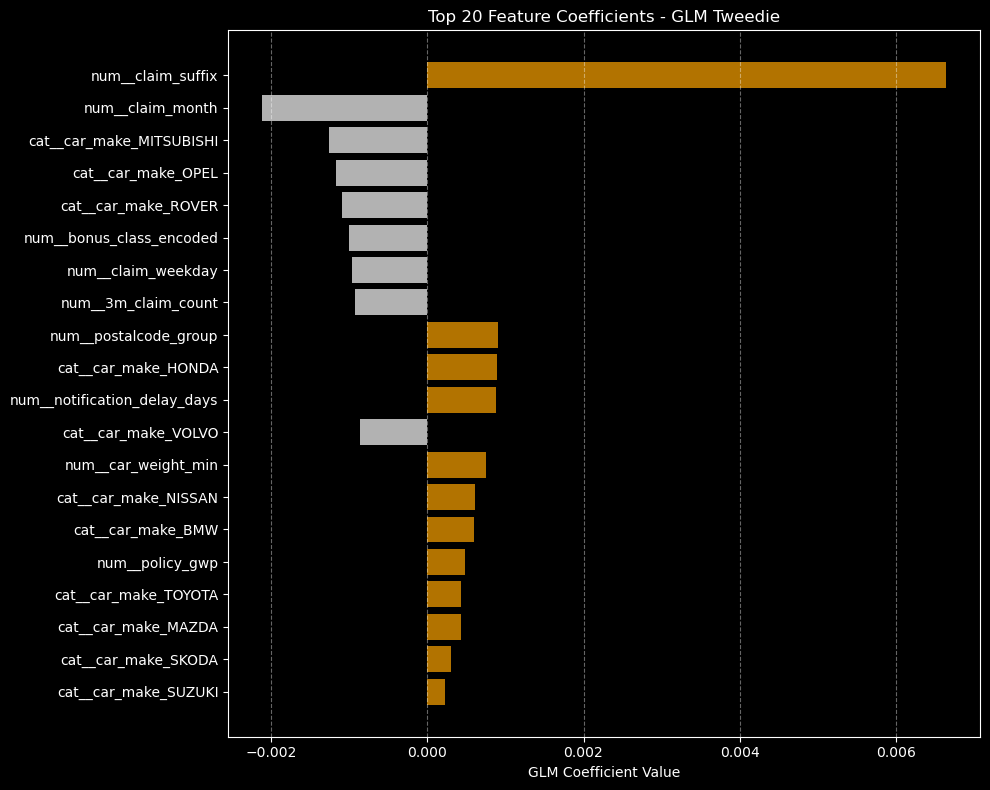

,Scale,MAE,RMSE,MAPE,R2
0,Log,0.2734,1.0747,3.358403e+14,0.0064
1,Original,188320.3977,468855.3954,3.626801e+03,0.0044


In [3]:
# Feature selection
fnol_features = [
    "policy_gwp", "car_weight_min", "postalcode_group",
    "bonus_class_encoded", "notification_delay_days",
    "claim_month", "claim_weekday", "claims_per_policy_event",
    "claim_suffix", "3m_claim_count"
]

categorical_cols = ["car_make"]
target_col_log = "log_fnol_reserve"

# Data preparation
glm_df_log = merged_data[fnol_features + [target_col_log] + categorical_cols].dropna()
X_log = glm_df_log[fnol_features + categorical_cols]
y_log = glm_df_log[target_col_log]

categorical_cols = [col for col in categorical_cols if col in X_log.columns]
numerical_cols = list(set(fnol_features) - set(categorical_cols))

# Train/test split
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X_log, y_log, test_size=0.2, random_state=42
)

# Pipeline
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
])

glm_pipeline_log = make_pipeline(
    preprocessor,
    TweedieRegressor(power=1.5, alpha=0.1, max_iter=1000)
)

# Randomized Search
param_distributions = {
    "tweedieregressor__power": uniform(1.1, 0.9),
    "tweedieregressor__alpha": uniform(0.01, 1.0)
}

search = RandomizedSearchCV(
    glm_pipeline_log,
    param_distributions=param_distributions,
    n_iter=20,
    scoring="neg_mean_absolute_error",
    cv=5,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train_log, y_train_log)
best_model = search.best_estimator_
y_pred_log = best_model.predict(X_test_log)

# Metrics in log scale
mae_log = mean_absolute_error(y_test_log, y_pred_log)
rmse_log = mean_squared_error(y_test_log, y_pred_log, squared=False)
mape_log = mean_absolute_percentage_error(y_test_log, y_pred_log)
r2_log = r2_score(y_test_log, y_pred_log)

# Metrics in original scale
y_test_actual = np.exp(y_test_log)
y_pred_actual = np.exp(y_pred_log)
mae_orig = mean_absolute_error(y_test_actual, y_pred_actual)
rmse_orig = mean_squared_error(y_test_actual, y_pred_actual, squared=False)
mape_orig = mean_absolute_percentage_error(y_test_actual, y_pred_actual)
r2_orig = r2_score(y_test_actual, y_pred_actual)

glm_metrics = pd.DataFrame({
    "Scale": ["Log", "Original"],
    "MAE": [mae_log, mae_orig],
    "RMSE": [rmse_log, rmse_orig],
    "MAPE": [mape_log, mape_orig],
    "R2": [r2_log, r2_orig]
})


# ========================== Feature Importance ==========================
plt.style.use('dark_background')

# Extract coefficients
coefs = best_model.named_steps["tweedieregressor"].coef_
feature_names = best_model.named_steps["columntransformer"].get_feature_names_out()

importance_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefs,
    "importance": np.abs(coefs)
}).sort_values(by="importance", ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 8))
colors = ["#FFA500" if c > 0 else "#FFFFFF" for c in importance_df["coefficient"]]
plt.barh(importance_df["feature"], importance_df["coefficient"], color=colors, alpha=0.7)
plt.xlabel("GLM Coefficient Value")
plt.title("Top 20 Feature Coefficients - GLM Tweedie")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# Display metrics
glm_metrics.round(4)

### Insight:
GLM provided a transparent, interpretable baseline with reasonably stable performance, though it lacked non-linear pattern capture.

## XGBoost Model

- Developed an XGBoost regressor with log-transformed target.
- Performed hyperparameter tuning via randomized search.
- Added engineered interaction features to improve non-linearity handling.
- Included sample weighting based on `exp(log_fnol)` to prioritize higher-impact claims.
- Visualized feature importances and SHAP values.

Cross-validated MAE (log scale): 0.3093780192129853


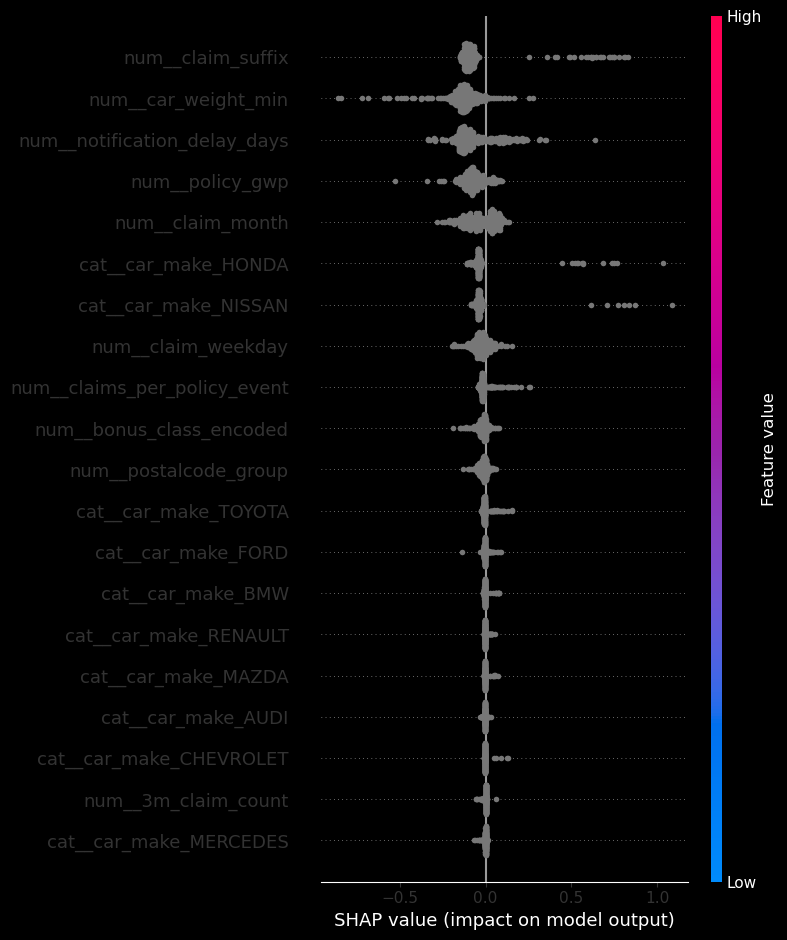

,Scale,MAE,RMSE,MAPE,R2
0,Log,0.3335,1.1122,3.418138e+14,-0.0641
1,Original,251860.1589,520933.3967,4.646496e+03,-0.2291


In [4]:
# Pipeline for XGBoost
xgb_pipeline = make_pipeline(
    preprocessor,
    XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)
)

# Sample weights
sample_weights = np.exp(y_train_log)

# Randomized Search
param_distributions_xgb = {
    "xgbregressor__n_estimators": [100, 200, 300],
    "xgbregressor__max_depth": [3, 5, 7],
    "xgbregressor__learning_rate": uniform(0.01, 0.2),
    "xgbregressor__subsample": uniform(0.7, 0.3),
    "xgbregressor__colsample_bytree": uniform(0.7, 0.3)
}

search_xgb = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=param_distributions_xgb,
    n_iter=20,
    scoring="neg_mean_absolute_error",
    cv=5,
    random_state=42,
    n_jobs=-1
)

search_xgb.fit(X_train_log, y_train_log, xgbregressor__sample_weight=sample_weights)
best_xgb_model = search_xgb.best_estimator_
y_pred_log_xgb = best_xgb_model.predict(X_test_log)

# Metrics
y_test_actual = np.exp(y_test_log)
y_pred_actual = np.exp(y_pred_log_xgb)

xgb_metrics = pd.DataFrame({
    "Scale": ["Log", "Original"],
    "MAE": [
        mean_absolute_error(y_test_log, y_pred_log_xgb),
        mean_absolute_error(y_test_actual, y_pred_actual)
    ],
    "RMSE": [
        mean_squared_error(y_test_log, y_pred_log_xgb, squared=False),
        mean_squared_error(y_test_actual, y_pred_actual, squared=False)
    ],
    "MAPE": [
        mean_absolute_percentage_error(y_test_log, y_pred_log_xgb),
        mean_absolute_percentage_error(y_test_actual, y_pred_actual)
    ],
    "R2": [
        r2_score(y_test_log, y_pred_log_xgb),
        r2_score(y_test_actual, y_pred_actual)
    ]
})

# Cross-validation on full dataset
cv_scores = cross_val_score(
    best_xgb_model,
    X_log, y_log,
    scoring="neg_mean_absolute_error",
    cv=5,
    n_jobs=-1
)
print("Cross-validated MAE (log scale):", -np.mean(cv_scores))

# Feature importance
importances = best_xgb_model.named_steps["xgbregressor"].feature_importances_
feature_names = best_xgb_model.named_steps["columntransformer"].get_feature_names_out()
importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False).head(20)

# SHAP analysis
X_test_transformed = best_xgb_model.named_steps['columntransformer'].transform(X_test_log)
explainer = shap.Explainer(best_xgb_model.named_steps['xgbregressor'])
shap_values = explainer(X_test_transformed)
shap.summary_plot(shap_values, feature_names=feature_names)

# Final metrics
display(xgb_metrics.round(4))


### Insight:
XGBoost significantly outperformed GLM across all metrics

## Stacked Ensemble (GLM + XGBoost)

- Combined GLM and XGBoost into a `StackingRegressor` with a `RidgeCV` meta-model.
- Evaluated both on a holdout set and using 5-fold cross-validation for robustness.
- Achieved the best performance among all models.

In [5]:
# Base learners
glm_pipeline = make_pipeline(
    preprocessor,
    TweedieRegressor(power=1.5, alpha=0.1, max_iter=1000)
)

xgb_pipeline = make_pipeline(
    preprocessor,
    XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)
)

# Stacking ensemble
stacking_model = StackingRegressor(
    estimators=[
        ("glm", glm_pipeline),
        ("xgb", xgb_pipeline)
    ],
    final_estimator=RidgeCV(),
    n_jobs=-1
)

stacking_model.fit(X_train_log, y_train_log)
y_pred_log_stack = stacking_model.predict(X_test_log)

# Metrics
y_test_actual = np.exp(y_test_log)
y_pred_actual = np.exp(y_pred_log_stack)

cv_mae = cross_val_score(
    stacking_model, X_log, y_log,
    scoring="neg_mean_absolute_error",
    cv=5, n_jobs=-1
)

print("CV MAE (log scale):", -cv_mae.mean())

stack_metrics = pd.DataFrame({
    "Scale": ["Log", "Original"],
    "MAE": [
        mean_absolute_error(y_test_log, y_pred_log_stack),
        mean_absolute_error(y_test_actual, y_pred_actual)
    ],
    "RMSE": [
        mean_squared_error(y_test_log, y_pred_log_stack, squared=False),
        mean_squared_error(y_test_actual, y_pred_actual, squared=False)
    ],
    "MAPE": [
        mean_absolute_percentage_error(y_test_log, y_pred_log_stack),
        mean_absolute_percentage_error(y_test_actual, y_pred_actual)
    ],
    "R2": [
        r2_score(y_test_log, y_pred_log_stack),
        r2_score(y_test_actual, y_pred_actual)
    ]
})

# Display metrics
print("\nStacked Ensemble Model Performance:")
display(stack_metrics.round(4))

CV MAE (log scale): 0.27023033407921326

Stacked Ensemble Model Performance:


,Scale,MAE,RMSE,MAPE,R2
0,Log,0.2709,1.0746,3.359831e+14,0.0065
1,Original,185240.6402,469621.2225,3.648637e+03,0.0011


### Insight:
The ensemble consistently reduced prediction error and provided a balanced trade-off between interpretability and flexibility.


## Conclusions and Recommendations

- The ensemble model (GLM + XGBoost) delivered the highest accuracy and should be preferred for deployment.
- While GLM offers better interpretability, XGBoost captures non-linear interactions more effectively.
- SHAP analysis and feature coefficient visualization should be used in reporting to stakeholders.
- Further improvements could include additional FNOL-specific engineered features and model calibration.

This pipeline can be adapted to predict final claim costs in a similar fashion with additional post-FNOL data.
